# Superposed Epoch Analysis 20CR runs
- opens all the 20CR data on precipitation pr and surface temperature tmp
- calculates monthly anomalies (based on 5-yr climatology) for 4 spatial regions (global, SH, Aus, E Aus) and 5 eruptions
- calculates percentiles (10, 90) to show model spread
- superposes the time-series for 5 eruptions plus mmm for tmp and pr and different regions (superposed epoch analysis)

## notebook for pinatubo and global results which are now working cos i split it into hemispheres 

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import seaborn as sns
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import sys 
# sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook
sys.path.append('/g/data/w48/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
import dask.distributed
import tempfile

tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

Client Scheduler: tcp://127.0.0.1:41737 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [4]:
path = '/g/data/w48/kb6999/Reanalysis/20CR_SEA_data_for_plots/'
# choose which variable to save as netcdfs
# var = 'tmp'
var = 'pr'

In [5]:
# create a list of member names excluding member 70 cos that file is problematic 
members = [*range(1,70),*range(71,81)]

## open raw netcdfs

In [6]:
# create a list of the paths and then open all members 
if var == 'tmp':
    print('var=tmp')
    tmp_paths = [f"/g/data/w48/kb6999/Reanalysis/20CR_TMP_raw_members/R_raw_Glob_TMP{m:02d}.nc" for m in members]
    ds_tmp = xr.open_mfdataset(tmp_paths, combine='nested', concat_dim='member', chunks={'time': 100})
    ds_tmp.coords['member'] = members
    reanal = xr.Dataset({'tmp': ds_tmp.TMP})


if var == 'pr':
    print('var=pr')
    pr_paths = [f"/g/data/w48/kb6999/Reanalysis/20CR_PRATE_raw_members/R_raw_Glob_PRATE{m:02d}.nc" for m in members]
    ds_pr = xr.open_mfdataset(pr_paths, combine='nested', concat_dim='member', chunks={'time': 100})
    ds_pr.coords['member'] = members
    reanal = xr.Dataset({'pr': ds_pr.PRATE})


var=pr


In [7]:
# area weighting 
reanal_w = reanal*np.cos(reanal.lat*(np.pi/180))
reanal_w

,Array,Chunk
Bytes,153.68 GiB,100.00 MiB
Shape,"(79, 1992, 256, 512)","(1, 100, 256, 512)"
Count,6400 Tasks,1580 Chunks
Type,float64,numpy.ndarray


Right now I have all the members stored in one array so from hereafter I can calculate anomalies etc.  
## Dates and volcano names

In [8]:
volcanoes = ['Krakatoa', 'Santa Maria','Agung','El Chichon', 'Pinatubo']
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

eruptions = {v: d for v, d in zip(volcanoes, e_date)}
eruptions

{'Krakatoa': Timestamp('1883-08-01 00:00:00'),
 'Santa Maria': Timestamp('1902-10-01 00:00:00'),
 'Agung': Timestamp('1963-03-01 00:00:00'),
 'El Chichon': Timestamp('1982-04-01 00:00:00'),
 'Pinatubo': Timestamp('1991-06-01 00:00:00')}

In [9]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [10]:
print(e_pre5yrs[4], e_pre3mon[4], e_post5yrs[4])

1986-06-01 00:00:00 1991-03-01 00:00:00 1996-07-01 00:00:00


## Select out regions and eruption dates

In [11]:
# select out hte 10 year time frame around each eruption (5yrs before and after)
# Krakatoa = reanal_w.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
# SantaMaria = reanal_w.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
# Agung = reanal_w.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
# ElChicon = reanal_w.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo = reanal_w.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

## scott climatology 

In [12]:
path_pr = '/g/data/w48/kb6999/Reanalysis/20CR_SEA_pr_data/'

In [13]:
# open clim 
# K_mon_clim_Glob = xr.open_dataset(f'{path_pr}K_clim_Glob_{var}.nc', chunks={'member': 1})
# S_mon_clim_Glob = xr.open_dataset(f'{path_pr}S_clim_Glob_{var}.nc', chunks={'member': 1})
# A_mon_clim_Glob = xr.open_dataset(f'{path_pr}A_clim_Glob_{var}.nc', chunks={'member': 1})
# E_mon_clim_Glob = xr.open_dataset(f'{path_pr}E_clim_Glob_{var}.nc', chunks={'member': 1})
P_mon_clim_Glob = xr.open_dataset(f'{path_pr}P_clim_Glob_{var}.nc', chunks={'member': 1})
P_mon_clim_Glob

,Array,Chunk
Bytes,0.93 GiB,12.00 MiB
Shape,"(12, 79, 256, 512)","(12, 1, 256, 512)"
Count,80 Tasks,79 Chunks
Type,float64,numpy.ndarray


# need to redo Pinatubo anom cos something is going wrong... (slicing with an out of order chunk???

In [14]:
# K_anom = Krakatoa.groupby('time.month') - K_mon_clim_Glob
# S_anom = SantaMaria.groupby('time.month') - S_mon_clim_Glob
# A_anom = Agung.groupby('time.month') - A_mon_clim_Glob
# E_anom = ElChicon.groupby('time.month') - E_mon_clim_Glob
P_anom = Pinatubo.groupby('time.month') - P_mon_clim_Glob
P_anom

,Array,Chunk
Bytes,9.33 GiB,1.00 MiB
Shape,"(79, 121, 256, 512)","(1, 1, 256, 512)"
Count,24729 Tasks,9559 Chunks
Type,float64,numpy.ndarray


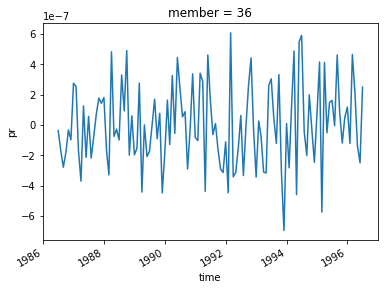

In [15]:
P_anom.mean(dim=['lat','lon']).sel(member=36).pr.plot()

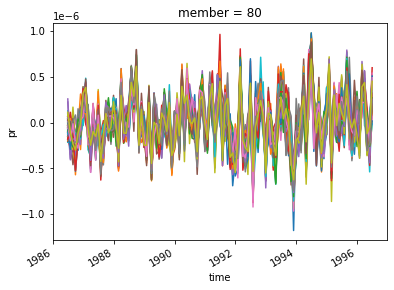

In [68]:
# plot all pinatubo members to see if there is a problem with one - doesn't seem to be 
fig,ax = plt.subplots(1,1)
for m in members:
    P_anom.mean(dim=['lat','lon']).sel(member=m).pr.plot(ax=ax)

In [18]:
start_date, end_date = e_pre3mon[4], e_post5yrs[4]
P_anom_SH_91 = P_anom.sel(time=slice(start_date, end_date)).sel(lat=slice(0,-90))
P_anom_NH_91 = P_anom.sel(time=slice(start_date, end_date)).sel(lat=slice(90,0))
P_anom_SH_91

,Array,Chunk
Bytes,2.47 GiB,512.00 kiB
Shape,"(79, 64, 128, 512)","(1, 1, 128, 512)"
Count,34841 Tasks,5056 Chunks
Type,float64,numpy.ndarray


In [19]:
start_date, end_date = e_pre5yrs[4], e_pre3mon[4]
P_anom_SH_86 = P_anom.sel(time=slice(start_date, end_date)).sel(lat=slice(0,-90))
P_anom_NH_86 = P_anom.sel(time=slice(start_date, end_date)).sel(lat=slice(90,0))
P_anom_NH_86

,Array,Chunk
Bytes,2.20 GiB,512.00 kiB
Shape,"(79, 57, 128, 512)","(1, 1, 128, 512)"
Count,33735 Tasks,4503 Chunks
Type,float64,numpy.ndarray


In [ ]:
start_date, end_date = e_pre3mon[4], e_post5yrs[4]
P_anom_NH_96 = P_anom.sel(time=slice(start_date, end_date)).sel(lat=slice(90,0))
P_anom_NH_96

In [22]:
# save off anoms for SEA plots for first half year period
with dask.diagnostics.ProgressBar():
    if var == 'pr':
        P_anom_SH_86.pr.to_netcdf(f'{path}P_anom_SH_{var}_1986-1991.nc')
#         P_anom_NH_86.pr.to_netcdf(f'{path}P_anom_NH_{var}_1986-1991.nc')

In [23]:
# save off anoms for SEA plots for second half year period
with dask.diagnostics.ProgressBar():
    if var == 'pr':
        P_anom_SH_91.pr.to_netcdf(f'{path}P_anom_SH_{var}_1991-1996.nc')
#         P_anom_NH_91.pr.to_netcdf(f'{path}P_anom_NH_{var}_1991-1996.nc')

In [26]:
P_mon_anom_SH_86 = xr.open_dataset(f'{path}P_anom_SH_{var}_1986-1991.nc', chunks={'member': 1})
P_mon_anom_NH_86 = xr.open_dataset(f'{path}P_anom_NH_{var}_1986-1991.nc', chunks={'member': 1})
P_mon_anom_SH_91 = xr.open_dataset(f'{path}P_anom_SH_{var}_1991-1996.nc', chunks={'member': 1})
P_mon_anom_NH_91 = xr.open_dataset(f'{path}P_anom_NH_{var}_1991-1996.nc', chunks={'member': 1})
P_mon_anom_NH_91

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 512, member: 79, time: 64)
Coordinates:
  * time     (time) datetime64[ns] 1991-03-31 1991-04-30 ... 1996-06-30
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... 2.456 1.754 1.053 0.3509
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
    month    (time) int64 dask.array<chunksize=(64,), meta=np.ndarray>
Data variables:
    pr       (member, time, lat, lon) float64 dask.array<chunksize=(1, 64, 128, 512), meta=np.ndarray>

In [53]:
P_mon_anom_SH = xr.open_mfdataset(f'{path}P_anom_SH_{var}*.nc', combine='by_coords', chunks={'member': 1})
P_mon_anom_NH = xr.open_mfdataset(f'{path}P_anom_NH_{var}*.nc', combine='by_coords', chunks={'member': 1})
P_mon_anom_SH

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 512, member: 79, time: 121)
Coordinates:
  * time     (time) datetime64[ns] 1986-06-30 1986-07-31 ... 1996-06-30
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 -0.3509 -1.053 -1.754 -2.456 ... -88.07 -88.77 -89.46
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
    month    (time) int64 dask.array<chunksize=(57,), meta=np.ndarray>
Data variables:
    pr       (member, time, lat, lon) float64 dask.array<chunksize=(1, 57, 128, 512), meta=np.ndarray>

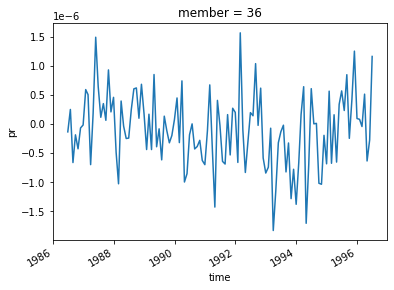

In [54]:
P_mon_anom_SH.mean(dim=['lat','lon']).sel(member=36).pr.plot()

## open netcdfs of anomalies

In [40]:
# ds=[]
# ds.append(P_mon_anom_SH)
# ds.append(P_mon_anom_NH)
# P_mon_anom_Glob = xr.concat(ds, dim=['lat','lon'], coords='minimal')
# P_mon_anom_Glob

In [ ]:
# open anoms 
K_mon_anom_Glob = xr.open_dataset(f'{path}K_mon_anom_Glob_{var}.nc')
S_mon_anom_Glob = xr.open_dataset(f'{path}S_mon_anom_Glob_{var}.nc')
A_mon_anom_Glob = xr.open_dataset(f'{path}A_mon_anom_Glob_{var}.nc')
E_mon_anom_Glob = xr.open_dataset(f'{path}E_mon_anom_Glob_{var}.nc')
# P_mon_anom_Glob = xr.open_dataset(f'{path}P_mon_anom_Glob_{var}.nc')
K_mon_anom_Glob

In [55]:
times = np.arange(-60,61)
# reset all the times so 0 corresponds to the eruption year and month
P_mon_anom_NH['time'] = times 
P_mon_anom_SH['time'] = times

# delete the months dimension (but not the time)
if 'month' in P_mon_anom_NH:
    del P_mon_anom_NH['month']
    del P_mon_anom_SH['month']

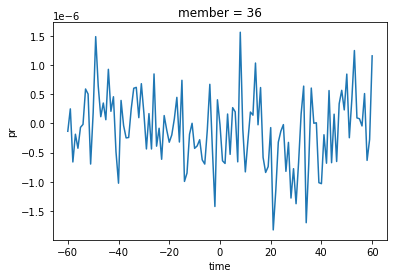

In [56]:
P_mon_anom_SH.mean(dim=['lat','lon']).sel(member=36).pr.plot()

In [ ]:
times = np.arange(-60,61)
# reset all the times so 0 corresponds to the eruption year and month
K_mon_anom_Glob['time'] = times
S_mon_anom_Glob['time'] = times
A_mon_anom_Glob['time'] = times
E_mon_anom_Glob['time'] = times 
# P_mon_anom_Glob['time'] = times

# delete the months dimension (but not the time)
if 'month' in A_mon_anom_Glob:
    del K_mon_anom_Glob['month']
    del S_mon_anom_Glob['month']
    del A_mon_anom_Glob['month']
    del E_mon_anom_Glob['month']
#     del P_mon_anom_Glob['month']

In [43]:
# import land fraction data
if var =='tmp':
    landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/Reanalysis/20CR_data_netcdfs/land_20CR.nc')
    landmask = landfrac_ds
    
if var =='pr':
    landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/Reanalysis/20CR_data_netcdfs/land_pr_20CR.nc')
    landmask = landfrac_ds

## krakatoa 

# won't take the lat lon mean for pr

In [ ]:
check = xr.open_dataset(f'{path}K_mon_Aus_{var}.nc')
check

## Take NH and then I can just average NH and SH

In [44]:
P_llm_NH = P_mon_anom_NH.mean(dim=['lat','lon'])
P_llm_SH = P_mon_anom_SH.mean(dim=['lat','lon'])
P_llm_NH

<xarray.Dataset>
Dimensions:  (member: 79, time: 121)
Coordinates:
  * time     (time) int64 -60 -59 -58 -57 -56 -55 -54 ... 54 55 56 57 58 59 60
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    pr       (member, time) float64 dask.array<chunksize=(1, 57), meta=np.ndarray>

In [47]:
with dask.diagnostics.ProgressBar():
    if var == 'pr':
        P_llm_SH.pr.to_netcdf(f'{path}P_llm_SH_{var}.nc')
        P_llm_NH.pr.to_netcdf(f'{path}P_llm_NH_{var}.nc')

In [59]:
landmask

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
Data variables:
    LAND     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0

In [60]:
P_mon_Aus = P_mon_anom_SH.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask.LAND==1, drop=True)
P_mon_EA = P_mon_anom_SH.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask.LAND==1, drop=True)
P_mon_Aus

,Array,Chunk
Bytes,182.91 MiB,1.22 MiB
Shape,"(79, 121, 44, 57)","(1, 64, 44, 57)"
Count,951 Tasks,158 Chunks
Type,float64,numpy.ndarray


In [61]:
P_llm_Aus = P_mon_Aus.mean(dim=('lat','lon'))
P_llm_EA = P_mon_EA.mean(dim=('lat','lon'))
P_llm_Aus

<xarray.Dataset>
Dimensions:  (member: 79, time: 121)
Coordinates:
  * time     (time) int64 -60 -59 -58 -57 -56 -55 -54 ... 54 55 56 57 58 59 60
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    pr       (member, time) float64 dask.array<chunksize=(1, 57), meta=np.ndarray>

In [62]:
# save off llm for SEA plots krakatoa
with dask.diagnostics.ProgressBar():
    if var == 'pr':
        P_llm_Aus.to_netcdf(f'{path}P_llm_Aus_{var}.nc')
        P_llm_EA.to_netcdf(f'{path}P_llm_EA_{var}.nc')

In [45]:
P_llm_Glob = (P_llm_NH + P_llm_SH)/2

In [46]:
with dask.diagnostics.ProgressBar():
    P_llm_Glob.pr.to_netcdf(f'{path}P_llm_Glob_{var}.nc')

In [ ]:
#  select out each region for each volvnao
# K_mon_NH = K_mon_anom_Glob.sel(lat=slice(90,0))
S_mon_NH = S_mon_anom_Glob.sel(lat=slice(90,0))
A_mon_NH = A_mon_anom_Glob.sel(lat=slice(90,0))
E_mon_NH = E_mon_anom_Glob.sel(lat=slice(90,0))
# P_mon_NH = K_mon_anom_Glob.sel(lat=slice(90,0))
S_mon_NH

In [ ]:
# take lat lon mean 
# K_llm_NH = K_mon_NH.mean(dim=('lat','lon'))
# S_llm_NH = S_mon_NH.mean(dim=('lat','lon'))
# A_llm_NH = A_mon_NH.mean(dim=('lat','lon'))
# E_llm_NH = E_mon_NH.mean(dim=('lat','lon'))
P_llm_NH = P_mon_NH.mean(dim=('lat','lon'))

In [ ]:
# save off llm for SEA plots krakatoa
with dask.diagnostics.ProgressBar():
    if var == 'pr':
#         K_llm_NH.pr.to_netcdf(f'{path}K_llm_NH_{var}.nc')
#         S_llm_NH.pr.to_netcdf(f'{path}S_llm_NH_{var}.nc')
#         A_llm_NH.pr.to_netcdf(f'{path}A_llm_NH_{var}.nc')
#         E_llm_NH.pr.to_netcdf(f'{path}E_llm_NH_{var}.nc')
        P_llm_NH.pr.to_netcdf(f'{path}P_llm_NH_{var}.nc')

In [6]:
K_llm_NH = xr.open_dataset(f'{path}K_llm_NH_{var}.nc')
K_llm_SH = xr.open_dataset(f'{path}K_llm_SH_{var}.nc')
K_llm_NH

<xarray.Dataset>
Dimensions:  (member: 79, time: 121)
Coordinates:
  * time     (time) int64 -60 -59 -58 -57 -56 -55 -54 ... 54 55 56 57 58 59 60
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    pr       (member, time) float64 ...

In [16]:
S_llm_NH = xr.open_dataset(f'{path}S_llm_NH_{var}.nc')
S_llm_SH = xr.open_dataset(f'{path}S_llm_SH_{var}.nc')
A_llm_NH = xr.open_dataset(f'{path}A_llm_NH_{var}.nc')
A_llm_SH = xr.open_dataset(f'{path}A_llm_SH_{var}.nc')
E_llm_NH = xr.open_dataset(f'{path}E_llm_NH_{var}.nc')
E_llm_SH = xr.open_dataset(f'{path}E_llm_SH_{var}.nc')
# P_llm_NH = xr.open_dataset(f'{path}P_llm_NH_{var}.nc')
# P_llm_SH = xr.open_dataset(f'{path}P_llm_SH_{var}.nc')
S_llm_NH

<xarray.Dataset>
Dimensions:  (member: 79, time: 121)
Coordinates:
  * time     (time) int64 -60 -59 -58 -57 -56 -55 -54 ... 54 55 56 57 58 59 60
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    pr       (member, time) float64 ...

In [17]:
# take the average over globe iet (SH and NH)/2
K_llm_Glob = (K_llm_NH + K_llm_SH)/2
S_llm_Glob = (S_llm_NH + S_llm_SH)/2
A_llm_Glob = (A_llm_NH + A_llm_SH)/2
E_llm_Glob = (E_llm_NH + E_llm_SH)/2
# P_llm_Glob = (P_llm_NH + P_llm_SH)/2

In [18]:
with dask.diagnostics.ProgressBar():
    K_llm_Glob.pr.to_netcdf(f'{path}K_llm_Glob_{var}.nc')
    S_llm_Glob.pr.to_netcdf(f'{path}S_llm_Glob_{var}.nc')
    A_llm_Glob.pr.to_netcdf(f'{path}A_llm_Glob_{var}.nc')
    E_llm_Glob.pr.to_netcdf(f'{path}E_llm_Glob_{var}.nc')
#     P_llm_Glob.pr.to_netcdf(f'{path}P_llm_Glob_{var}.nc')

In [11]:
with dask.diagnostics.ProgressBar():
    K_llm_Glob.pr.to_netcdf(f'{path}K_llm_Glob_{var}.nc')

In [ ]:
# calculate the monthly member mean for monthly anomalies
K_llm_Glob = K_mon_anom_Glob.mean(dim=('lat','lon'))
# K_llm_SH = K_mon_SH.mean(dim=('lat','lon'))
# K_llm_Aus = K_mon_Aus.mean(dim=('lat','lon'))
# K_llm_EA = K_mon_EA.mean(dim=('lat','lon'))
K_llm_Glob

In [ ]:
# save off llm for SEA plots krakatoa
with dask.diagnostics.ProgressBar():
    if var == 'tmp':
        K_llm_Glob.tmp.to_netcdf(f'{path}K_llm_Glob_{var}.nc')
        K_llm_SH.tmp.to_netcdf(f'{path}K_llm_SH_{var}.nc')
        K_llm_Aus.tmp.to_netcdf(f'{path}K_llm_Aus_{var}.nc')
        K_llm_EA.tmp.to_netcdf(f'{path}K_llm_EA_{var}.nc')
    elif var == 'pr':
        K_llm_Glob.pr.to_netcdf(f'{path}K_llm_Glob_{var}.nc')
#         K_llm_SH.pr.to_netcdf(f'{path}K_llm_SH_{var}.nc')
#         K_llm_Aus.pr.to_netcdf(f'{path}K_llm_Aus_{var}.nc')
#         K_llm_EA.pr.to_netcdf(f'{path}K_llm_EA_{var}.nc')

## santa maria

In [ ]:
# calculate the monthly member mean for monthly anomalies
S_llm_Glob = S_mon_anom_Glob.mean(dim=('lat','lon'))
# S_llm_SH = S_mon_SH.mean(dim=('lat','lon'))
# S_llm_Aus = S_mon_Aus.mean(dim=('lat','lon'))
# S_llm_EA = S_mon_EA.mean(dim=('lat','lon'))
S_llm_Glob

In [ ]:
# save off llm for SEA plots krakatoa
with dask.diagnostics.ProgressBar():
    if var == 'tmp':
        S_llm_Glob.tmp.to_netcdf(f'{path}S_llm_Glob_{var}.nc')
        S_llm_SH.tmp.to_netcdf(f'{path}S_llm_SH_{var}.nc')
        S_llm_Aus.tmp.to_netcdf(f'{path}S_llm_Aus_{var}.nc')
        S_llm_EA.tmp.to_netcdf(f'{path}S_llm_EA_{var}.nc')
    elif var == 'pr':
        S_llm_Glob.pr.to_netcdf(f'{path}S_llm_Glob_{var}.nc')
#         S_llm_SH.pr.to_netcdf(f'{path}S_llm_SH_{var}.nc')
#         S_llm_Aus.pr.to_netcdf(f'{path}S_llm_Aus_{var}.nc')
#         S_llm_EA.pr.to_netcdf(f'{path}S_llm_EA_{var}.nc')

## agung

In [ ]:
# calculate the monthly model mean for monthly anomalies
A_llm_Glob = A_mon_anom_Glob.mean(dim=('lat','lon'))
# A_llm_SH = A_mon_SH.mean(dim=('lat','lon'))
# A_llm_Aus = A_mon_Aus.mean(dim=('lat','lon'))
# A_llm_EA = A_mon_EA.mean(dim=('lat','lon'))
A_llm_Glob

In [ ]:
# save off llm for SEA plots krakatoa
with dask.diagnostics.ProgressBar():
    if var == 'tmp':
        A_llm_Glob.tmp.to_netcdf(f'{path}A_llm_Glob_{var}.nc')
        A_llm_SH.tmp.to_netcdf(f'{path}A_llm_SH_{var}.nc')
        A_llm_Aus.tmp.to_netcdf(f'{path}A_llm_Aus_{var}.nc')
        A_llm_EA.tmp.to_netcdf(f'{path}A_llm_EA_{var}.nc')
    elif var == 'pr':
#         A_llm_Glob.pr.to_netcdf(f'{path}A_llm_Glob_{var}.nc')
        A_llm_SH.pr.to_netcdf(f'{path}A_llm_SH_{var}.nc')
        A_llm_Aus.pr.to_netcdf(f'{path}A_llm_Aus_{var}.nc')
        A_llm_EA.pr.to_netcdf(f'{path}A_llm_EA_{var}.nc')

## el chichon

In [ ]:
# calculate the monthly model mean for monthly anomalies
E_llm_Glob = E_mon_anom_Glob.mean(dim=('lat','lon'))
# E_llm_SH = E_mon_SH.mean(dim=('lat','lon'))
# E_llm_Aus = E_mon_Aus.mean(dim=('lat','lon'))
# E_llm_EA = E_mon_EA.mean(dim=('lat','lon'))
E_llm_Glob

In [ ]:
# save off llm for SEA plots krakatoa
with dask.diagnostics.ProgressBar():
    if var == 'tmp':
        E_llm_Glob.tmp.to_netcdf(f'{path}E_llm_Glob_{var}.nc')
        E_llm_SH.tmp.to_netcdf(f'{path}E_llm_SH_{var}.nc')
        E_llm_Aus.tmp.to_netcdf(f'{path}E_llm_Aus_{var}.nc')
        E_llm_EA.tmp.to_netcdf(f'{path}E_llm_EA_{var}.nc')
    elif var == 'pr':
#         E_llm_Glob.pr.to_netcdf(f'{path}E_llm_Glob_{var}.nc')
        E_llm_SH.pr.to_netcdf(f'{path}E_llm_SH_{var}.nc')
        E_llm_Aus.pr.to_netcdf(f'{path}E_llm_Aus_{var}.nc')
        E_llm_EA.pr.to_netcdf(f'{path}E_llm_EA_{var}.nc')

## pinatubo

In [ ]:
with dask.diagnostics.ProgressBar():
#  select out each region for eac
    P_mon_SH = P_mon_anom_Glob.sel(lat=slice(0,-90)) 
    P_mon_Aus = P_mon_anom_Glob.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask.LAND==1, drop=True)
    P_mon_EA = P_mon_anom_Glob.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask.LAND==1, drop=True)

In [ ]:
# trying to save netcdf of each region before taking lat lon mean 
with dask.diagnostics.ProgressBar():
    if var == 'pr':
        P_mon_SH.pr.to_netcdf(f'{path}P_mon_SH_{var}.nc')
        P_mon_Aus.pr.to_netcdf(f'{path}P_mon_Aus_{var}.nc')
        P_mon_EA.pr.to_netcdf(f'{path}P_mon_EA_{var}.nc')

In [ ]:
# open each region 
P_mon_SH = xr.open_dataset(f'{path}P_mon_SH_{var}.nc')
P_mon_Aus = xr.open_dataset(f'{path}P_mon_Aus_{var}.nc')
P_mon_EA = xr.open_dataset(f'{path}P_mon_EA_{var}.nc')

In [ ]:
# calculate the monthly model mean for monthly anomalies
P_llm_Glob = P_mon_anom_Glob.mean(dim=('lat','lon'))
P_llm_SH = P_mon_SH.mean(dim=('lat','lon'))
P_llm_Aus = P_mon_Aus.mean(dim=('lat','lon'))
P_llm_EA = P_mon_EA.mean(dim=('lat','lon'))
P_llm_Aus

In [ ]:
# save off llm for SEA plots krakatoa
with dask.diagnostics.ProgressBar():
    if var == 'tmp':
        P_llm_Glob.tmp.to_netcdf(f'{path}P_llm_Glob_{var}.nc')
        P_llm_SH.tmp.to_netcdf(f'{path}P_llm_SH_{var}.nc')
        P_llm_Aus.tmp.to_netcdf(f'{path}P_llm_Aus_{var}.nc')
        P_llm_EA.tmp.to_netcdf(f'{path}P_llm_EA_{var}.nc')
    elif var == 'pr':
        P_llm_Glob.pr.to_netcdf(f'{path}P_llm_Glob_{var}.nc')
        P_llm_SH.pr.to_netcdf(f'{path}P_llm_SH_{var}.nc')
        P_llm_Aus.pr.to_netcdf(f'{path}P_llm_Aus_{var}.nc')
        P_llm_EA.pr.to_netcdf(f'{path}P_llm_EA_{var}.nc')